In [85]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F958196%2F1622250%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T114149Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D609fc86b2d6b0a37816fde4a3c4f5415ed11c47c18a6deb17c2c2a6d0d7d5a32839172b33792d38051c05a0fa285125c3e612375beef2f123a0dd4eb0b876eb0f06acad56a5923d24f13173b0ab86fa56b46256af079e5ac3da7b79a67b2ecad9644d0442945d45b92894a8bf8494de859976ff803fdb41a28152e19ad5c79a9be90e34894debbc7893b2f0aa30d1a9f151c61262795024b81ac4c29b355f1e4ea5b00b153642eb1c44a1d178dbf3b09b6d1690578f99ad77b6e43f27242242556de32c80cb1204c4d6925dc065b315f521accb08a394a1b45563cd52e057ffca88bcde0a42f8bdd2f574453efb068d0863093d8cf9ffd1a2ac801a9e0e62515'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1211141 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


## Introduction
This kernel is a simple example of fruit classification with a simple CNN implemented with Keras model and tools. Click the blue "Edit Notebook" or "Fork Notebook" button at the top of this kernel to begin editing.

## General Libs

In [86]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Analysis
Let's view some dataset samples.

This example uses keras ImageDataGenerator. This lib turns easier to read and use image classes from a subdirectoty structure.

### Reading the dataset

In [87]:
im_shape = (250,250)

TRAINING_DIR = '../input/ds_frutas_am/train'
TEST_DIR = '../input/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16

In [88]:
#Using keras ImageGenerator and flow_from_directoty

# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.15)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [89]:
# If you want data augmentation, uncomment and run this cell
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [90]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


### Showing some examples

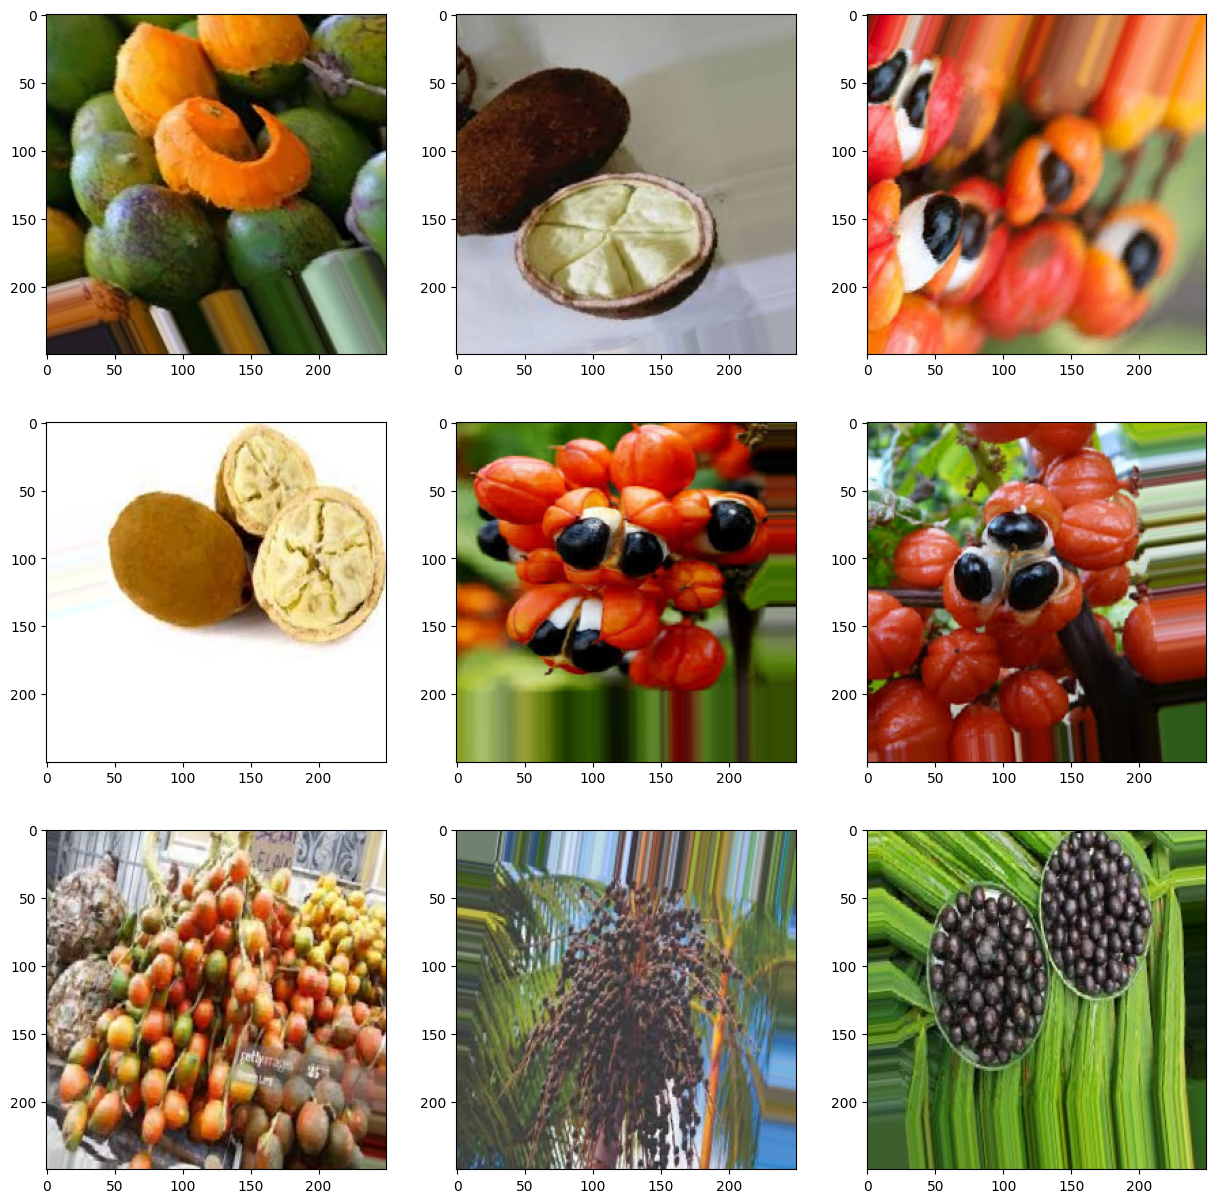

In [91]:
# Visualizing some examples
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

## Creating a simple CNN Model

In [92]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 248, 248, 20)      560       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 124, 124, 20)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 122, 122, 40)      7240      
                                                                 
 flatten_8 (Flatten)         (None, 595360)            0         
                                                                 
 dense_16 (Dense)            (None, 100)               59536100  
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                      

In [93]:
epochs = 100

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 71.8715 - accuracy: 0.1786
Epoch 1: val_loss improved from inf to 10.39889, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 23s 7s/step - loss: 71.8715 - accuracy: 0.1786 - val_loss: 10.3989 - val_accuracy: 0.1875
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 15.4806 - accuracy: 0.1964
Epoch 2: val_loss improved from 10.39889 to 4.27180, saving model to model.h5
4/4 [==============================] - 21s 6s/step - loss: 15.4806 - accuracy: 0.1964 - val_loss: 4.2718 - val_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 5.2759 - accuracy: 0.3393
Epoch 3: val_loss improved from 4.27180 to 2.59252, saving model to model.h5
4/4 [==============================] - 27s 8s/step - loss: 5.2759 - accuracy: 0.3393 - val_loss: 2.5925 - val_accuracy: 0.1875
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 2.2714 - accuracy: 0.3036
Epoch 4: val_loss improved from 2.59252 to 1.82425, saving model to model.h5
4/4 [==============================] - 26s 7s/step - loss: 2.2714 - accuracy: 0.3036 - val_loss: 1.8242 

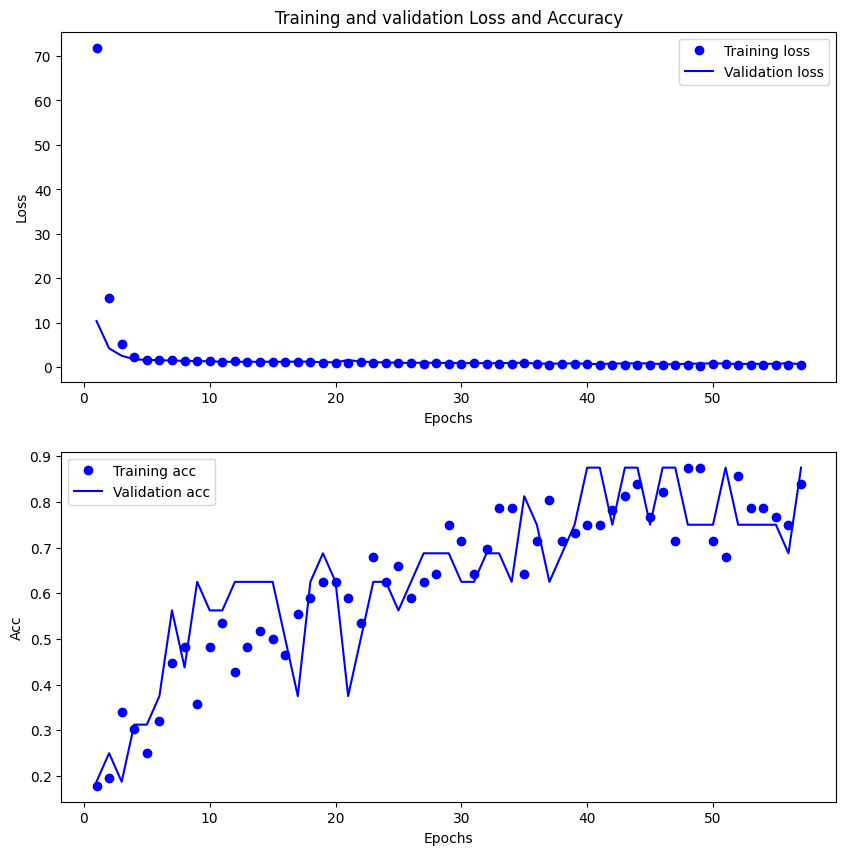

In [94]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Evaluating the model

In [95]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [96]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

<ipython-input-96-0b1386c018fa>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Val loss: 0.6773051023483276
Val accuracy: 0.8888888955116272


In [97]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-97-8baddd65724c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


Test loss: 0.6944748759269714
Test accuracy: 0.7333333492279053


In [98]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


<ipython-input-99-4a63cf876f11>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Classification Report
              precision    recall  f1-score   support

        acai       0.62      1.00      0.77         5
     cupuacu       1.00      0.40      0.57         5
    graviola       0.80      0.80      0.80         5
     guarana       0.62      1.00      0.77         5
     pupunha       1.00      0.40      0.57         5
      tucuma       0.80      0.80      0.80         5

    accuracy                           0.73        30
   macro avg       0.81      0.73      0.71        30
weighted avg       0.81      0.73      0.71        30



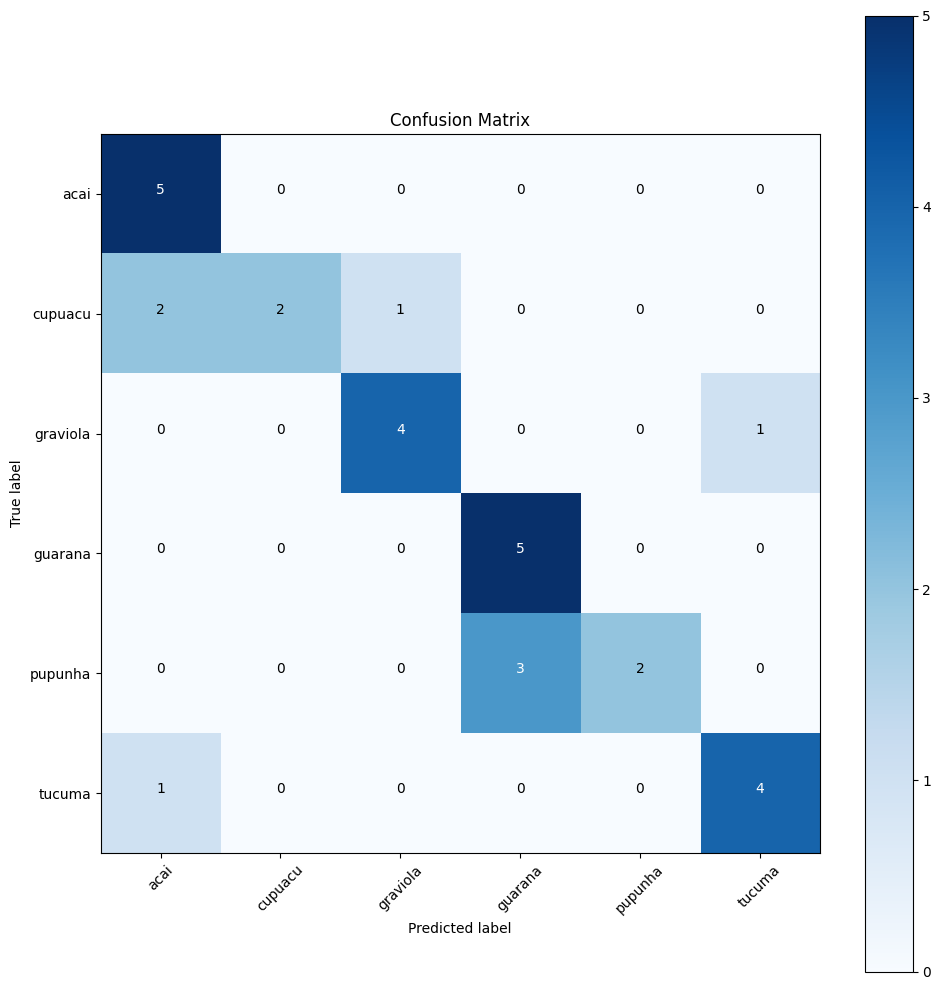

In [99]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))